In [1]:
import astropy.constants as c
import astropy.units as u
import numpy as np

# TOI-540
# https://exofop.ipac.caltech.edu/tess/target.php?id=200322593
Rs = 0.178 * u.R_sun
Ms = 0.157 * u.M_sun
w = 0.002524194
duration = 50.801648 * u.day # 2 sectors
dt = 2 * u.minute
sigma, omega = 0.01678591968956381, 8.87037925719471*(1/u.day)

def _taudelta_to_RP(tau_v, delta_v):
    depth = 2*sigma/delta_v
    Rp = np.sqrt(depth)*Rs
    
    T = (np.pi/(omega*tau_v)).to(u.hour)
    a = (c.G * Ms * T**2) / (4*(Rs**2))

    P = 2*np.pi*a**(3/2) / np.sqrt(c.G * Ms)
    P = P.decompose().to(u.day)
    
    n_tr = (duration/P).decompose()
    snr = (depth/w)*np.sqrt(n_tr*(T/dt).decompose())
    
    return Rp.to(u.R_earth).value, P.decompose().to(u.day).value, snr

taudelta_to_RP = np.vectorize(_taudelta_to_RP)

def _duration(P):
    P = P * u.day
    a = ((c.G*Ms*(P**2))/(4*(np.pi**2)))**(1/3)
    T = (P*Rs)/(np.pi*a)   
    return T

def _snr(Rp, P):
    P = P * u.day
    Rp = Rp * u.R_earth
    
    depth = (Rp/Rs)**2
    a = ((c.G*Ms*(P**2))/(4*(np.pi**2)))**(1/3)
    T = (P*Rs)/(np.pi*a)    
    n_tr = (duration/P)
    return (depth/w)*np.sqrt(n_tr*(T/dt))

SNR = np.vectorize(_snr)

def _RP_to_taudelta(Rp, P):
    P = P * u.day
    Rp = Rp * u.R_earth
    
    depth = (Rp/Rs)**2
    delta_v = (2*sigma/depth).decompose()
    a = ((c.G*Ms*(P**2))/(4*(np.pi**2)))**(1/3)
    T = (P*Rs)/(np.pi*a)
    
    tau_v = (np.pi/(omega*T))
    
    n_tr = (duration/P)
    snr = (depth/w)*np.sqrt(n_tr*(T/dt))
    
    return float(tau_v.decompose()), float(delta_v.decompose()), float(snr.decompose())

RP_to_taudelta = np.vectorize(_RP_to_taudelta, )

In [2]:
RP_to_taudelta(0.51, 1.19)

(array(13.391408), array(48.6559714), array(7.79360961))

# Plot Frans

Text(0.5, 0, '$\\tau_v \\propto \\frac{\\mathrm{variability\\; timescale}}{\\mathrm{transit\\;duration}}$')

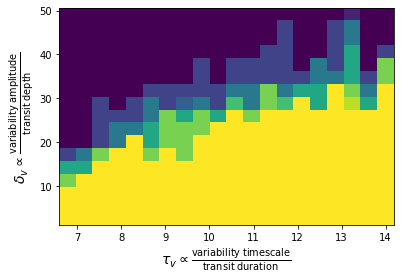

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

tls_reports = glob("../../data/fran_ir/*")
original_df = pd.concat([pd.read_csv(f) for f in tls_reports])
original_df = original_df.rename_axis('i')
df = original_df.sort_values(["i",'found'],ascending=[True, False]).groupby("i").head(1)
#df = pd.read_csv("../../data/fran_ir/a_tls_report_WS0.csv")
radius, period, fran_found = df[["radius", "period", "found"]].values.T.astype(float)
fran_tau_v, fran_delta_v, _ = RP_to_taudelta(radius, period)

bins=(20, 17)
found = df.found.values
stats = binned_statistic_2d(fran_tau_v, fran_delta_v, fran_found, bins=bins)
im = plt.imshow(
    stats.statistic.T, 
    origin="lower",
    extent=(
        stats.x_edge.min(), 
        stats.x_edge.max(), 
        stats.y_edge.min(), 
        stats.y_edge.max()
    ),
    aspect="auto",
)
plt.ylabel(r"$\delta_v \propto \frac{\mathrm{variability\; amplitude}}{\mathrm{transit\;depth}}$", fontsize=14)
plt.xlabel(r"$\tau_v \propto \frac{\mathrm{variability\; timescale}}{\mathrm{transit\;duration}}$", fontsize=14)

# nuance

In [181]:
def right_candidate(t0, period, true_t0, true_period, verbose=False):
    t0_check = np.abs((t0  - true_t0 + 0.5 * true_period) % true_period - 0.5 * true_period)%period < 0.02
    period_check = np.abs(period - true_period) < 0.1
    same = np.logical_and(t0_check, period_check)
    if verbose:
        if not same:
            if not t0_check:
                output = f"t0 differ: {t0:.2e} {true_t0:.2e}"
            if not period_check:
                output = f"period differ: {period:.2e} {true_period:.2e}"
        else:
            output = "match"
        return same, output
    else:
        return same

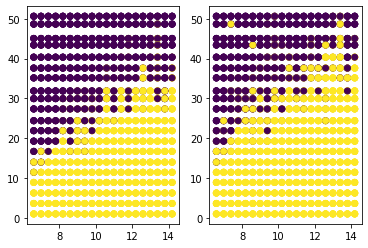

In [182]:
from glob import glob
import yaml

files = glob("../../data/results/*.yaml")
full_results = []
for f in files:
    period = eval(f.split("/")[-1].split("_")[0][1::])
    radius = eval(f.split("/")[-1].split("_")[1][1::])
    t0 = eval(f.split("/")[-1].split("_")[2][0:-5]) - 1410.9042195659338
    tau_v, delta_v, snr = _RP_to_taudelta(radius, period)
    results = yaml.full_load(open(f, "r"))
    if len(results)>1:
        # check origi£nal candidate
        detected = right_candidate(results[0], results[2], t0, period) or right_candidate(results[0], results[2], t0, period/2)
    else:
        detected = True
    
    if not detected:
        pass
        #print(results[2], period)
    
    full_results.append((tau_v, delta_v, detected))   

plt.subplot(122)
tau_v, delta_v, detected = np.array(full_results).T
plt.scatter(tau_v, delta_v, c=detected)

plt.subplot(121)
plt.scatter(fran_tau_v, fran_delta_v, c=fran_found)

Text(0.5, 0, '$\\tau_v \\propto \\frac{\\mathrm{variability\\; timescale}}{\\mathrm{transit\\;duration}}$')

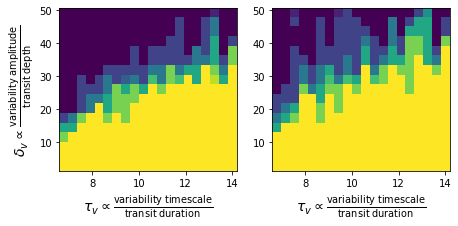

In [183]:
plt.figure(None, (7, 3))

bins=(20, 17)
found = df.found.values
stats = binned_statistic_2d(tau_v, delta_v, detected, bins=bins)

plt.subplot(122)
im = plt.imshow(
    stats.statistic.T, 
    origin="lower",
    extent=(
        stats.x_edge.min(), 
        stats.x_edge.max(), 
        stats.y_edge.min(), 
        stats.y_edge.max()
    ),
    aspect="auto",
)
plt.xlabel(r"$\tau_v \propto \frac{\mathrm{variability\; timescale}}{\mathrm{transit\;duration}}$", fontsize=14)

plt.subplot(121)
stats = binned_statistic_2d(fran_tau_v, fran_delta_v, fran_found, bins=bins)
im = plt.imshow(
    stats.statistic.T, 
    origin="lower",
    extent=(
        stats.x_edge.min(), 
        stats.x_edge.max(), 
        stats.y_edge.min(), 
        stats.y_edge.max()
    ),
    aspect="auto",
)
plt.ylabel(r"$\delta_v \propto \frac{\mathrm{variability\; amplitude}}{\mathrm{transit\;depth}}$", fontsize=14)
plt.xlabel(r"$\tau_v \propto \frac{\mathrm{variability\; timescale}}{\mathrm{transit\;duration}}$", fontsize=14)

In [186]:
wtls = np.count_nonzero(fran_found)
nuance = np.count_nonzero(detected)

(nuance-wtls)/wtls

0.162534435261708